## **What comes next?: Using Bayesian Inference to Model Human Musical Expectation**
Authors: Breanna Nguyen and Ilker Yildirim  
Institution: Yale University, Department of Psychology

### **Generative Model**

In [1]:
# Import dependecies
import Pkg
Pkg.activate("psyc261")
Pkg.add(["CSV", "DataFrames"])
Pkg.add("Distributions")
Pkg.add("HypothesisTests")
Pkg.add("GLM")
using Gen
using Plots
using CSV
using DataFrames
using Distributions
using Statistics
using HypothesisTests
using Random
using GLM
include("utils/draw.jl")
;

  Activating project at `~/Algorithms-of-the-Mind/finalproj/psyc261`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/finalproj/psyc261/Manifest.toml`


In [2]:
## I create this struct and some helper functions to be used later on in the model
struct MusicalScale
    name::Symbol
    notes::Vector{Int}
end

function create_scale(name::Symbol, root_note::Int, intervals::Vector{Int})
    notes = Int[]
    note = root_note

    for interval in intervals
        note = root_note + interval
        push!(notes, note)
    end

    return MusicalScale(name, notes)
end

function notes(scale::MusicalScale)
    return scale.notes
end

# This function creates a major scale using the specific intervals in all major scales, I limited it to 
# one octave (8 notes) because most of the melodies do not operate outside of this
function create_major_scale(root_note::Int)
    return create_scale(Symbol("major"), root_note, [0, 2, 4, 5, 7, 9, 11, 12])#, 14, 16, 17, 19, 21, 23, 24])
end

# This function finds the degree of a note in a scale if it exists, and the nearest stable note if not
function findnearest(value, array, exclude=nothing)
    filtered_array = isnothing(exclude) ? array : filter(x -> x != exclude, array)
    idx = argmin(abs.(value .- filtered_array))
    return filtered_array[idx]
end

# I create some major scales for the model to draw from later on
C = create_major_scale(60)
G = create_major_scale(55)  
D = create_major_scale(62)  
A = create_major_scale(57)  
E = create_major_scale(64)  
B = create_major_scale(59)  
F♯ = create_major_scale(66)
G♭ = create_major_scale(66)
D♭ = create_major_scale(61)
A♭ = create_major_scale(56)
E♭ = create_major_scale(63)
B♭ = create_major_scale(58)
F = create_major_scale(65)

# This is only for the generative model to randomly draw from when it is called on its own
major_scales = [C, G, D, A, E, B, F♯, G♭, D♭, A♭, E♭, B♭, F]
;

In [3]:
# This function finds the degree of the current note or the degree of the closest stable note 
# to the current note and multiplies it by -0.03. If the note is higher than the entire scale, 
# more gravity force is applied to bring it back down. If the note is lower than the entire scale,
# no gravity is applied

function calculate_gravity(note::Float64, key::MusicalScale)
    degree = findfirst(x -> x == note, values(notes(key)))

    if degree != nothing
        gravity_force = -0.03 * degree
    elseif note > notes(key)[end]
        nearest_stable_pitch = findnearest(note, values(key.notes))
        gravity_force = -0.03 * abs(note - (notes(key)[end]))
    elseif note < notes(key)[1] 
        gravity_force = 0
    else
        gravity_force = -0.05
    end

    return gravity_force
end
;

In [4]:
# This function finds the difference between the inverse squares of the distance to the nearest stable
# pitch in both directions. This is taken straight from the literature.

function calculate_magnetism(note::Float64, key::MusicalScale)
    magnetism_force = 0.0
    nearest_stable_pitch = findnearest(note, values(notes(key)))

    dto = abs(note - nearest_stable_pitch)
    dfrom = abs(note - findnearest(note, values(notes(key)), nearest_stable_pitch))

    # This is so we don't get -Inf from dividng by 0
    if dto != 0.0 && dfrom != 0.0
        magnetism_force = (1/dto)^2 - (1/dfrom)^2
    end

    return magnetism_force
end
;

In [5]:
# This function returns a positive value if the melody is ascending and a negative value if the melody
# is descending. If the note is the same as the previous note, then inertia = 0.

function calculate_inertia(note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    inertia_force = 0.0
    degree = findfirst(x -> x == note, values(notes(key)))

    # Retrieve last note from sequence
    prev_note = tmp_sequence[end]
    
    if note > prev_note
        inertia_force = degree !== nothing ? 0.5 : 0.5
    elseif note < prev_note
        inertia_force = degree !== nothing ? -0.5 : -0.5
    end
    
    return inertia_force
end
;

In [6]:
# Initialize params
σ_gravity = 0.2
σ_magnetism = 0.2
σ_inertia = 0.5
σ_note = 5
w_g = 1
w_m = 9
w_i = 3
;

In [7]:
@gen function melody_kernel(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    push!(tmp_sequence, curr_note)
    
    # First, calculate each force for the current note
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ_gravity), :gravity)
    magnetism = @trace(normal(calculate_magnetism(round(curr_note), key), σ_magnetism), :magnetism)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ_inertia), :inertia)

    # Add all forces together to get cumulative `F`
    force = w_g*gravity + w_m*magnetism + w_i*inertia

    # Apply force to note, resulting value is used as mu for a normal dist. from which the next note is drawn
    # from
    next_note = @trace(normal((curr_note + force), σ_note), :note)

    # This is so I can calculate the last note ONLY, will be used in particle filter
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ_gravity), :last_gravity)
    magnetism = @trace(normal(calculate_magnetism(round(curr_note), key), σ_magnetism), :last_magnetism)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ_inertia), :last_inertia)
    force = w_g*gravity + w_m*magnetism + w_i*inertia
    last_note = @trace(normal((next_note + force), σ_note), :last_note)

    return round(next_note, digits = 2)
end 

chain = Gen.Unfold(melody_kernel)
;

In [8]:
@gen function melody(K::Int)
    σ = 0.05
    
    #This is so I can keep track of note directions for inertia
    tmp_sequence = []

    #Choose some things to start the melody
    key = @trace(draw(major_scales, (ones(length(major_scales)) / length(major_scales))), :key)
    start = @trace(normal((notes(key)[8]), σ), :start)
    init_note = round(start)

    sequence = @trace(chain(K, init_note, key, tmp_sequence), :sequence)

    return sequence
end
;

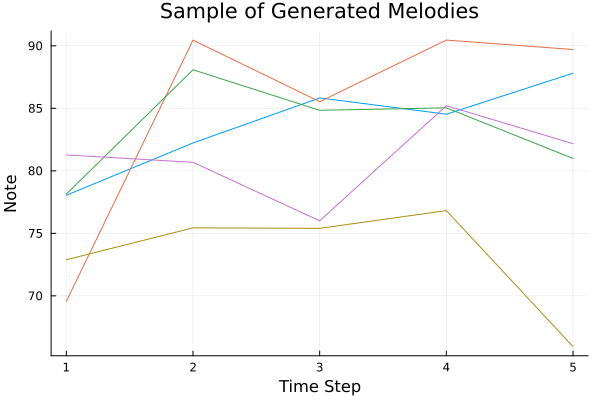

In [9]:
num_traces = 5
traces = Vector{Gen.DynamicDSLTrace}(undef, num_traces)
vecs = Vector{Vector{Float64}}(undef, num_traces)

for i in 1:num_traces
    trace = Gen.simulate(melody, (5,))
    vec = convert(Vector{Float64}, Array(get_retval(trace)))

    traces[i] = trace
    vecs[i] = vec
end

plot(vecs, line=:solid, legend=false)
xlabel!("Time Step")
ylabel!("Note")
title!("Sample of Generated Melodies")

In [10]:
trace = Gen.simulate(melody, (5,))
get_retval(trace)

Persistent{Any}[68.75, 69.76, 64.62, 63.7, 65.62]

In [11]:
get_choices(trace)

│
├── :key : MusicalScale(:major, [58, 60, 62, 63, 65, 67, 69, 70])
│
├── :start : 70.10253439559929
│
└── :sequence
    │
    ├── 1
    │   │
    │   ├── :last_magnetism : 0.14627950111263022
    │   │
    │   ├── :note : 68.74634948882006
    │   │
    │   ├── :magnetism : 0.4682648939304217
    │   │
    │   ├── :last_inertia : -0.02834652898910183
    │   │
    │   ├── :gravity : -0.6134157711484334
    │   │
    │   ├── :last_gravity : -0.3432470008920362
    │   │
    │   ├── :last_note : 70.00122082286518
    │   │
    │   └── :inertia : 0.059032375445460215
    │
    ├── 2
    │   │
    │   ├── :last_magnetism : -0.2344862676582322
    │   │
    │   ├── :note : 69.75720680771137
    │   │
    │   ├── :magnetism : -0.2067114695184681
    │   │
    │   ├── :last_inertia : 0.1268228702090735
    │   │
    │   ├── :gravity : -0.2600238743708353
    │   │
    │   ├── :last_gravity : 0.08891066375886149
    │   │
    │   ├── :last_note : 66.76429183789028
    │   │
    │   └── :inert

### **Inference**

In [12]:
function make_observations(df::DataFrame, idx::Int64)
    melody_sequence = df[!, idx]
    return melody_sequence
end
;

In [13]:
function particle_filter(num_particles::Int, num_samples::Int, key::MusicalScale, sequence)
    init_note = sequence[1]
    
    # Initial observations
    init_obs = Gen.choicemap(
        (:key, key),
        (:start, init_note)
    )

    sequence = sequence[2:length(sequence)]

    # Initialize the particle filter
    state = Gen.initialize_particle_filter(melody, (0,), init_obs, num_particles)

    for idx in 1:length(sequence)
        # Evolve and resample
        Gen.maybe_resample!(state, ess_threshold=num_particles / 3)

        # Load observations of this time step
        obs = Gen.choicemap(
            (:sequence => idx => :note, sequence[idx])
        )

        # Re-weight by the likelihood
        Gen.particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end
    
    # Return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end
;

In [14]:
function calculate_sequence(pf_trace, observed_notes)
    sequence = [observed_notes[1]]
    choices = get_choices(pf_trace)
    for i in 1:length(observed_notes)-1
        grav = choices[:sequence => i => :gravity]
        mag = choices[:sequence => i => :magnetism]
        inert = choices[:sequence => i => :inertia]

        next_note = (w_g * grav + w_m * mag + w_i * inert) + sequence[end]
        push!(sequence, next_note)
    end
    push!(sequence, (choices[:sequence => length(observed_notes)-1 => :last_note]))
    return sequence
end
;

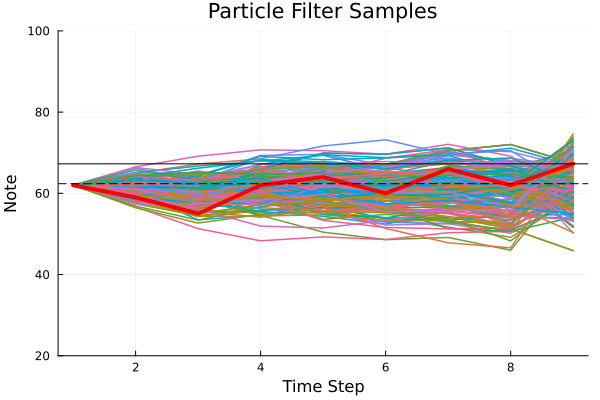

In [15]:
function visualize_samples(pf_traces, observed_notes)
    all_sequences = []
    last_notes = []

    for trace in pf_traces
        sequence = calculate_sequence(trace, observed_notes[1:length(observed_notes)-1])
        push!(last_notes, sequence[end])
        push!(all_sequences, sequence)
    end

    mean_last_note = mean(last_notes)

    plot(all_sequences, linewidth=1.5, line=:solid, legend=false)
    plot!(observed_notes, linewidth=4, linecolor=:red, linestyle=:solid)
    hline!([observed_notes[end]], line=:solid, linecolor=:black, label="Observed Last Note")
    hline!([mean_last_note], line=:dash, linecolor=:black, label="Mean Last Note")
    xlabel!("Time Step")
    ylabel!("Note")
    ylims!((20, 100))
    title!("Particle Filter Samples")
    display(Plots.plot!())
end

# Test case
key = G
observed_notes = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0, 67.27]
pf_traces = particle_filter(2000, 200, key, observed_notes)
visualize_samples(pf_traces, observed_notes)

In [16]:
calculate_sequence(pf_traces[100], observed_notes[1:length(observed_notes)-1])
get_choices(pf_traces[100])

│
├── :key : MusicalScale(:major, [55, 57, 59, 60, 62, 64, 66, 67])
│
├── :start : 62.0
│
└── :sequence
    │
    ├── 1
    │   │
    │   ├── :last_magnetism : 0.18857648993403398
    │   │
    │   ├── :note : 59.0
    │   │
    │   ├── :magnetism : 0.10473201143443134
    │   │
    │   ├── :last_inertia : -0.32810746956007225
    │   │
    │   ├── :gravity : 0.0034563366009615903
    │   │
    │   ├── :last_gravity : 0.12125962991236253
    │   │
    │   ├── :last_note : 61.794332719829335
    │   │
    │   └── :inertia : 0.041196014355204875
    │
    ├── 2
    │   │
    │   ├── :last_magnetism : -0.19060408290878023
    │   │
    │   ├── :note : 55.0
    │   │
    │   ├── :magnetism : 0.014393249147231751
    │   │
    │   ├── :last_inertia : -0.04203330299250406
    │   │
    │   ├── :gravity : -0.0414016668583663
    │   │
    │   ├── :last_gravity : -0.14101915768492954
    │   │
    │   ├── :last_note : 57.04467046965255
    │   │
    │   └── :inertia : -0.1742699935199125
    │

### **Log Likelihood Plot**

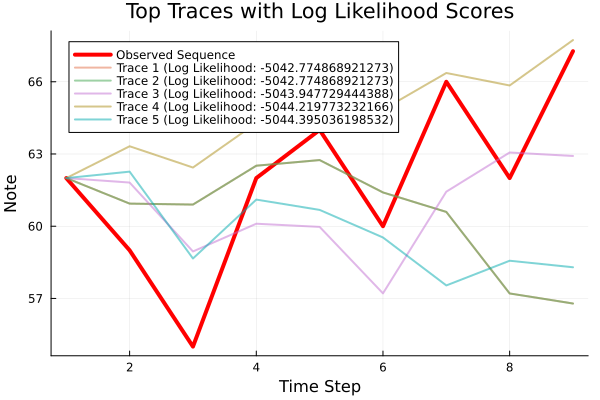

In [17]:
sorted_traces = sort(pf_traces, by=trace -> Gen.get_score(trace), rev=true)

num_traces_to_visualize = 5

plot(observed_notes, linewidth=4, linecolor=:red, linestyle=:solid, label="Observed Sequence")

for (idx, trace) in enumerate(sorted_traces[1:min(num_traces_to_visualize, length(sorted_traces))])
    sequence = calculate_sequence(trace, observed_notes)
    plot!(sequence[1:length(sequence)-1], linewidth=2, alpha=0.5, label="Trace $idx (Log Likelihood: $(Gen.get_score(trace)))")
end

xlabel!("Time Step")
ylabel!("Note")
title!("Top Traces with Log Likelihood Scores")
display(Plots.plot!())

### **Model vs Human Performance**

In [18]:
all_keys = [D,C,E,E♭,D♭,B♭,G,B,E♭,E,B,F♯,E♭,E,D♭,A♭,C,G,F,E♭,F♯,A♭,B♭,F,C,G,D,A,A♭,B♭,F,D,A,B,F♯,E♭,F,D,E,B,F♯,D♭,A♭,B♭,F]

# I had to make separate df's for different melody lengths, the code breaks otherwise
df6 = DataFrame(CSV.File("./data_v2/stems6.csv"))
melodies6 = []
for col in names(df6)
    push!(melodies6, df6[!, col][1:7])
end
df6_keys = [D,C]
actual_means6 = Array(df6[7, :])

df7 = DataFrame(CSV.File("./data_v2/stems7.csv"))
melodies7 = []
for col in names(df7)
    push!(melodies7, df7[!, col][1:8])
end
df7_keys = [E,E♭,D♭,B♭]
actual_means7 = Array(df7[8, :])

df8 = DataFrame(CSV.File("./data_v2/stems8.csv"))
melodies8 = []
for col in names(df8)
    push!(melodies8, df8[!, col][1:9])
end
df8_keys = [G,B,E♭,E,B,F♯,E♭,E,D♭,A♭,C,G,F,E♭]
actual_means8 = Array(df8[9, :])

df9 = DataFrame(CSV.File("./data_v2/stems9.csv"))
melodies9 = []
for col in names(df9)
    push!(melodies9, df9[!, col][1:10])
end
df9_keys = [F♯,A♭,B♭,F,C,G,D,A,A♭,B♭,F,D,A,B,F♯,E♭,F,D,E,B,F♯,D♭,A♭,B♭,F]
actual_means9 = Array(df9[10, :])

actual_means = vcat(actual_means6, actual_means7, actual_means8, actual_means9)
;

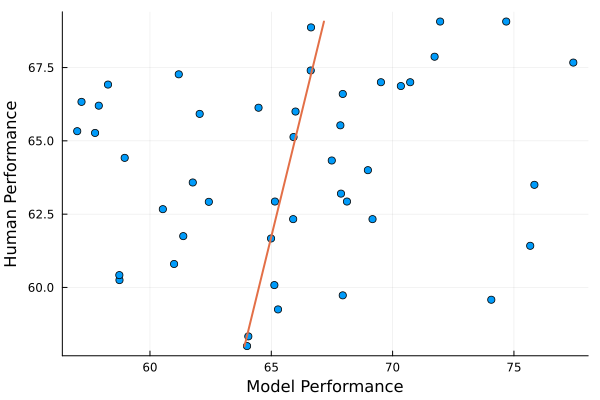

R value = 0.166248847726676, R-squared value = 0.027638679370447394, p = 0.2750680417405603


In [19]:
function calculate_model_means(df, df_keys)
    num_melodies = size(df, 2)
    model_means = []

    for idx in 1:num_melodies
        obs_notes = make_observations(df, idx)
        key = df_keys[idx]
        pf_traces = particle_filter(2000, 200, key, obs_notes)

        last_notes = Float64[]
        for trace in pf_traces
            last_note = (calculate_sequence(trace, obs_notes[1:end-1]))[end]
            push!(last_notes, last_note)
        end

        mean_last_notes = mean(last_notes)
        push!(model_means, mean_last_notes)
    end

    return model_means
end

Random.seed!(704)
model_means_6 = calculate_model_means(df6, df6_keys)
model_means_7 = calculate_model_means(df7, df7_keys)
model_means_8 = calculate_model_means(df8, df8_keys)
model_means_9 = calculate_model_means(df9, df9_keys)
model_means = vcat(model_means_6, model_means_7, model_means_8, model_means_9)

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)
viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

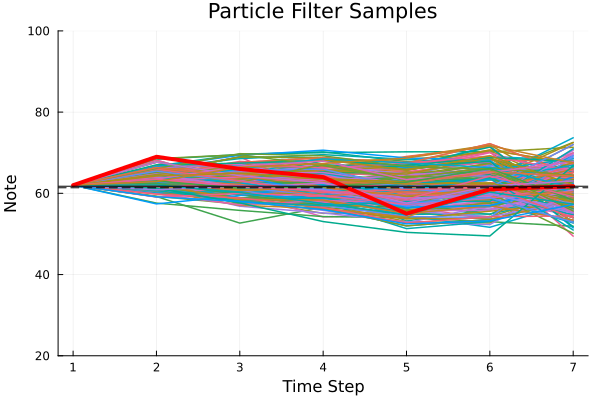

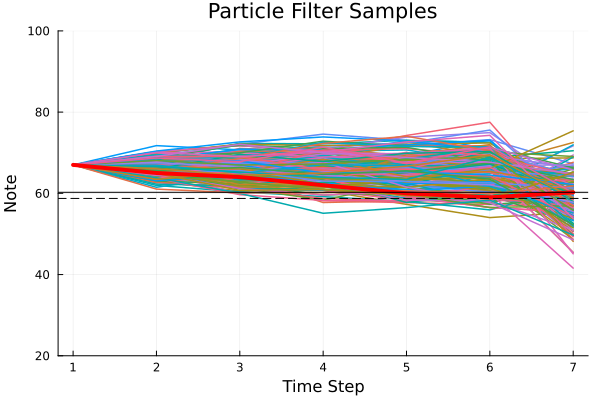

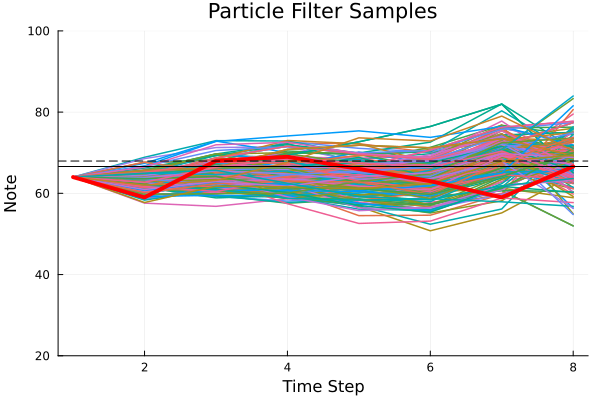

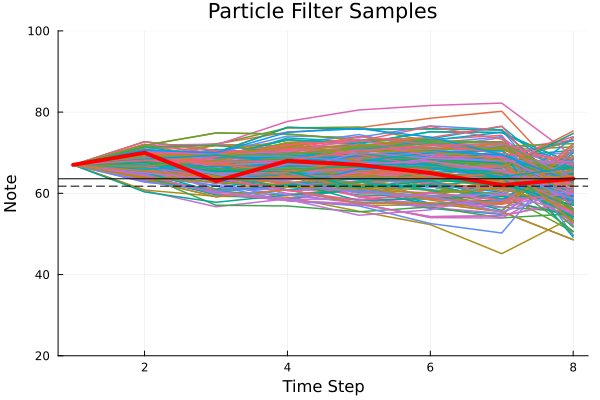

In [ ]:
Random.seed!(704)
num_melodies = size(df6, 2)
model_means = []
for idx in 1:num_melodies
    obs_notes = make_observations(df6, idx)
    pf_traces = particle_filter(2000, 200, df6_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    visualize_samples(pf_traces, obs_notes)
end

num_melodies = size(df7, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df7, idx)
    pf_traces = particle_filter(2000, 200, df7_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
    visualize_samples(pf_traces, obs_notes)
end

num_melodies = size(df8, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df8, idx)
    pf_traces = particle_filter(2000, 200, df8_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
    visualize_samples(pf_traces, obs_notes)
end


num_melodies = size(df9, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df9, idx)
    pf_traces = particle_filter(2000, 200, df9_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
    visualize_samples(pf_traces, obs_notes)
end
;

### **Ablation**

#### **Subset with just magnetism and inertia, no gravity**

In [ ]:
@gen function melody_kernel_no_grav(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.4
    w_m = 9
    w_i = 2
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    magnetism = @trace(normal(calculate_magnetism(round(curr_note), key), σ), :magnetism)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :inertia)

    #Add all forces together to get cumulative `F`
    force = w_m*magnetism + w_i*inertia

    #Apply force to find next note
    next_note = @trace(normal((curr_note + force), 3), :note)

    # This is so I can calculate the last note ONLY
    magnetism = @trace(normal(calculate_magnetism(round(curr_note), key), σ), :last_magnetism)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :last_inertia)
    force = w_m*magnetism + w_i*inertia
    last_note = @trace(normal((next_note + force), 3), :last_note)

    return round(next_note, digits = 2)
end 

chain = Gen.Unfold(melody_kernel_no_grav)

function calculate_sequence(pf_trace, observed_notes)
    sequence = [observed_notes[1]]
    choices = get_choices(pf_trace)
    for i in 1:length(observed_notes)-1
        mag = choices[:sequence => i => :magnetism]
        inert = choices[:sequence => i => :inertia]

        next_note = (9 * mag + 2 * inert) + sequence[end]
        push!(sequence, next_note)
    end
    push!(sequence, choices[:sequence => length(observed_notes)-1 => :last_note])
    return sequence
end

num_melodies = size(df6, 2)
model_means = []
for idx in 1:num_melodies
    obs_notes = make_observations(df6, idx)
    pf_traces = particle_filter(2000, 200, df6_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes)[end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df7, idx)
    pf_traces = particle_filter(2000, 200, df7_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes)[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

num_melodies = size(df8, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df8, idx)
    pf_traces = particle_filter(2000, 200, df8_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes)[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df9, idx)
    pf_traces = particle_filter(2000, 200, df9_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes)[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

#### **Subset with just gravity and inertia, no magnetism**

In [ ]:
@gen function melody_kernel_no_mag(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.5
    w_g = 1
    w_i = 2
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :gravity)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :inertia)

    #Add all forces together to get cumulative `F`
    force = w_g*gravity + w_i*inertia

    #Apply force to find next note
    next_note = @trace(normal((curr_note + force), 3), :note)

    # This is so I can calculate the last note ONLY
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :last_gravity)
    inertia = @trace(normal(calculate_inertia(curr_note, key, tmp_sequence), σ), :last_inertia)
    force = w_g*gravity + w_i*inertia
    last_note = @trace(normal((next_note + force), 3), :last_note)

    return round(next_note, digits = 2)
end 

chain = Gen.Unfold(melody_kernel_no_mag)

function calculate_sequence(pf_trace, observed_notes)
    sequence = [observed_notes[1]]
    choices = get_choices(pf_trace)
    for i in 1:length(observed_notes)-1
        grav = choices[:sequence => i => :gravity]
        inert = choices[:sequence => i => :inertia]

        next_note = (1 * grav + 2 * inert) + sequence[end]
        push!(sequence, next_note)
    end
    push!(sequence, choices[:sequence => length(observed_notes)-1 => :last_note])
    return sequence
end

num_melodies = size(df6, 2)
model_means = []
for idx in 1:num_melodies
    obs_notes = make_observations(df6, idx)
    pf_traces = particle_filter(2000, 200, df6_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df7, idx)
    pf_traces = particle_filter(2000, 200, df7_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

num_melodies = size(df8, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df8, idx)
    pf_traces = particle_filter(2000, 200, df8_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df9, idx)
    pf_traces = particle_filter(2000, 200, df9_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")

#### **Subset with just gravity and magnetism, no inertia**

In [ ]:
@gen function melody_kernel_no_in(k::Int, curr_note::Float64, key::MusicalScale, tmp_sequence::Vector{Any})
    σ = 0.5
    w_g = 1
    w_m = 9
    push!(tmp_sequence, curr_note)
    
    #First, calculate each force
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :gravity)
    magnetism = @trace(normal(calculate_magnetism(round(curr_note), key), σ), :magnetism)

    #Add all forces together to get cumulative `F`
    force = w_g*gravity + w_m*magnetism

    #Apply force to find next note
    next_note = @trace(normal((curr_note + force), 3), :note)

    # This is so I can calculate the last note ONLY
    gravity = @trace(normal(calculate_gravity(curr_note, key), σ), :last_gravity)
    magnetism = @trace(normal(calculate_magnetism(round(curr_note), key), σ), :last_magnetism)
    force = w_g*gravity + w_m*obs_notes[1:length(obs_notes)-1]
    last_note = @trace(normal((next_note + force), 3), :last_note)

    return round(next_note, digits = 2)
end 

chain = Gen.Unfold(melody_kernel_no_in)

function calculate_sequence(pf_trace, observed_notes)
    sequence = [observed_notes[1]]
    choices = get_choices(pf_trace)
    for i in 1:length(observed_notes)-1
        grav = choices[:sequence => i => :gravity]
        mag = choices[:sequence => i => :magnetism]

        next_note = (1 * grav + 9 * mag) + sequence[end]
        push!(sequence, next_note)
    end
    push!(sequence, choices[:sequence => length(observed_notes)-1 => :last_note])
    return sequence
end

num_melodies = size(df6, 2)
model_means = []
for idx in 1:num_melodies
    obs_notes = make_observations(df6, idx)
    pf_traces = particle_filter(2000, 200, df6_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end
    
    push!(model_means, mean(last_notes))
    
end

num_melodies = size(df7, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df7, idx)
    pf_traces = particle_filter(2000, 200, df7_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

num_melodies = size(df8, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df8, idx)
    pf_traces = particle_filter(2000, 200, df8_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end


num_melodies = size(df9, 2)
for idx in 1:num_melodies
    obs_notes = make_observations(df9, idx)
    pf_traces = particle_filter(2000, 200, df9_keys[idx], obs_notes)

    last_notes = Float64[]
    for trace in pf_traces
        last_note = calculate_sequence(trace, obs_notes[1:length(obs_notes)-1])[end]
        push!(last_notes, last_note)
    end

    push!(model_means, mean(last_notes))
end

r_value = cor(actual_means, model_means)
ctest = CorrelationTest(actual_means, model_means)
p_value = pvalue(ctest)

viz = scatter(model_means, actual_means, xlabel="Model Performance", ylabel="Human Performance", legend=false)
df = DataFrame(Y = convert(Array{Float64, 1}, model_means), x = convert(Array{Float64, 1}, actual_means))
line = lm(@formula(Y~x), df)
rsq = r2(line)
x_vals = range(minimum(df.x), maximum(df.x), length=100)
y_vals = predict(line, DataFrame(x=x_vals))

display(plot!(viz, y_vals, x_vals, linewidth=2))
println("R value = $r_value, R-squared value = $rsq, p = $p_value")